# Training

In [1]:
import torch
# import sys; sys.path.insert(0, '..')
import torchnam
print(torchnam.__version__)

0.1.0


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Settings

In [3]:
PATH = "./models/"
MODEL_NAME = "Test"
DATA = "Credit"
SAVE_PATH = PATH + DATA + '_' + MODEL_NAME

### Load Data

In [4]:
import torchnam
from torchnam.datasets import TabularDatasets

In [5]:
data = TabularDatasets(data_name=DATA, root="./data/")
train_loader, test_loader = data.get_loader(batch_size=2000,
                                            make_balanced_train=True)
n_features = data.n_features

Data Loaded!
Train Data Length : 227845
Test Data Length : 56962


### Load Model

In [6]:
import torch.nn as nn
from torchnam.modules.grouplinear import GroupLinear, ResGroupLinear
from torchnam.nam import NAM

In [7]:
h_dim = 32

feature_model = nn.Sequential(
    GroupLinear(1, h_dim, n_features, bias=True),
    nn.BatchNorm1d(h_dim*n_features),
    nn.ReLU(),
    ResGroupLinear(h_dim, h_dim, n_features, bias=True),
    nn.ReLU(),
    ResGroupLinear(h_dim, h_dim, n_features, bias=True),
    nn.ReLU(),
    ResGroupLinear(h_dim, h_dim, n_features, bias=True),
    nn.ReLU(),
    GroupLinear(h_dim, 1, n_features, bias=True),
)

model = NAM(feature_model, n_features, n_classes=1, n_tasks=1)
model = model.to(device)

### Check Validity

In [8]:
for x, y in train_loader:
    break
    
print("x:", x.shape)
print("y:", y.shape)
print("output:", model(x.to(device)).shape)

x: torch.Size([2000, 30])
y: torch.Size([2000])
output: torch.Size([2000, 1])


### Start Training

In [9]:
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
num_epochs = 5

In [10]:
for epoch in range(num_epochs):    
    for i, (x, y) in enumerate(train_loader):
        pre = model(x.to(device))
        cost = loss(pre, y.to(device).reshape(-1, 1).float())
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) % 50 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_loader), cost.item()))
    
print("Learning Finished!")

Epoch [1/5], lter [50/113], Loss: 0.1396
Epoch [1/5], lter [100/113], Loss: 0.1037
Epoch [2/5], lter [50/113], Loss: 0.0628
Epoch [2/5], lter [100/113], Loss: 0.0671
Epoch [3/5], lter [50/113], Loss: 0.0498
Epoch [3/5], lter [100/113], Loss: 0.0443
Epoch [4/5], lter [50/113], Loss: 0.0358
Epoch [4/5], lter [100/113], Loss: 0.0407
Epoch [5/5], lter [50/113], Loss: 0.0424
Epoch [5/5], lter [100/113], Loss: 0.0275
Learning Finished!


## Explainability

In [20]:
model = model.eval()

In [26]:
for x, y in test_loader:
    break

In [29]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [22]:
sample = x[0:1]

In [23]:
sample

tensor([[ 1.6076e+05, -6.7447e-01,  1.4081e+00, -1.1106e+00, -1.3284e+00,
          1.3890e+00, -1.3084e+00,  1.8859e+00, -6.1423e-01,  3.1165e-01,
          6.5076e-01, -8.5778e-01, -2.2996e-01, -1.9982e-01,  2.6637e-01,
         -4.6544e-02, -7.4140e-01, -6.0562e-01, -3.9257e-01, -1.6265e-01,
          3.9432e-01,  8.0084e-02,  8.1003e-01, -2.2433e-01,  7.0790e-01,
         -1.3584e-01,  4.5102e-02,  5.3384e-01,  2.9132e-01,  2.3000e+01]])

In [41]:
# 'hidden':'batch_size x n_clases x n_features',
# 'bias':'n_clases',
# 'out':'batch_size x n_classes',
hidden, bias, out = model.forward_with_feature(sample.to(device))

In [42]:
hidden, bias, out

(tensor([[[ 5.3317e-01,  5.0626e-01,  1.5152e-01,  1.7856e-01, -4.7412e+00,
            6.3261e-03, -4.4585e-01,  9.1365e-01,  4.8374e-01, -2.1646e-01,
           -5.3532e-01, -5.1379e-01,  3.3274e-01, -8.5870e-02, -2.0713e+00,
           -2.3290e-01,  1.7546e-02, -3.4018e-01, -2.5015e-01, -7.9432e-01,
           -2.3567e-01, -2.7551e-03,  3.4510e-01, -2.2492e-02,  7.2458e-01,
           -6.7345e-02, -5.4306e-01,  1.0293e-01, -2.9127e-02, -1.7343e-01]]],
        device='cuda:0', grad_fn=<MulBackward0>),
 tensor([0.0361], device='cuda:0', grad_fn=<ViewBackward>),
 tensor([[-6.9690]], device='cuda:0', grad_fn=<AddBackward0>))

Text(0, 0.5, 'Features')

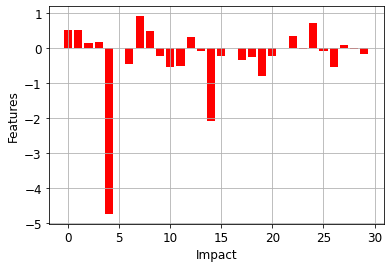

In [51]:
import matplotlib.pyplot as plt
import numpy as np
plt.grid()
plt.bar(np.arange(n_features), hidden.cpu().detach().numpy()[0, 0], color='r')
plt.xlabel("Impact")
plt.ylabel("Features")

## What's the function shape of Feature 4?

In [54]:
max_value, min_value = x[:, 4].max(), x[:, 4].min()

In [69]:
step = 0.1
dummy_index = torch.arange(min_value, max_value+step, step)
dummy_samples = torch.stack([dummy_index]*n_features, dim=1)
hidden, bias, out = model.forward_with_feature(dummy_samples.to(device))

Text(0, 0.5, 'Function Value')

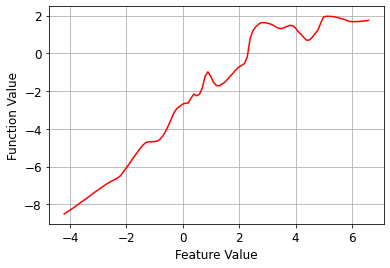

In [71]:
# 'hidden':'batch_size x n_clases x n_features',
plt.grid()
plt.plot(dummy_index, hidden[:, :, 4].cpu().detach().numpy(), color='r')
plt.xlabel("Feature Value")
plt.ylabel("Function Value")

Conclusion: As feature #4 increases, the probability increases.